In [14]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import os

In [15]:
file_path = "../mushroom_network_no_edges.pkl"

with open(file_path, 'rb') as f:
    data = pd.read_pickle(f)

In [16]:
# Print number of nodes
print(f"Number of nodes: {data.number_of_nodes()}")

# Print number of edges
print(f"Number of edges: {data.number_of_edges()}")

# Print node attributes
print("Node attributes:")
count = 0
for node, attrs in data.nodes(data=True):
    print(f"Node {node}: {attrs}")
    count += 1
    if count >= 5:
        break

Number of nodes: 1101
Number of edges: 0
Node attributes:
Node 1: {'mushroom': 'Russula maculata', 'id': 1, 'views_all_time': 9897, 'article': 'https://en.wikipedia.org/wiki/Russula_maculata', 'sporePrintColor': ['yellow', 'ochre'], 'howEdible': [], 'stipeCharacter': ['bare'], 'capShape': ['convex', 'depressed'], 'hymeniumType': ['adnexed', 'free'], 'ecologicalType': ['mycorrhizal'], 'whichGills': ['Gills on hymenium'], 'conservation_status': [], 'image': 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/1996-02-15_Russula_maculata_Qu%C3%A9l._%26_Roze_117.jpg/250px-1996-02-15_Russula_maculata_Qu%C3%A9l._%26_Roze_117.jpg', 'Genus': 'Russula', 'Family': 'Russulaceae', 'Order': 'Russulales', 'Class': 'Agaricomycetes', 'Division': 'Basidiomycota', 'Species': 'R.\xa0maculata', 'text': 'Russula maculata is a species of mushroom in the genus Russula . [ 1 ] Its cap ranges from 4–10 centimetres ( 1 + 1 ⁄ 2 –4\xa0in) wide, with hues varying from whitish to red. [ 2 ] It is difficult to

In [17]:
# Get all nodes into a dataframe with their attributes
df = pd.DataFrame.from_dict(dict(data.nodes(data=True)), orient='index')

In [18]:
# Filter out rows with missing values in 'Species' column
df = df.dropna(subset=['Species'])

In [19]:
# See column datatypes
print("Column datatypes:")
print(df.dtypes)

Column datatypes:
mushroom               object
id                      int64
views_all_time          int64
article                object
sporePrintColor        object
howEdible              object
stipeCharacter         object
capShape               object
hymeniumType           object
ecologicalType         object
whichGills             object
conservation_status    object
image                  object
Genus                  object
Family                 object
Order                  object
Class                  object
Division               object
Species                object
text                   object
wikilinks              object
dtype: object


## TAXONOMY PRELIMINARY ANALYSIS

In [20]:
# 1. Setup and Basic Cleaning
# Ensure views are numeric
df['views_all_time'] = pd.to_numeric(df['views_all_time'], errors='coerce').fillna(0)


In [21]:
# Define taxonomic ranks in order
tax_ranks = ['Division', 'Class', 'Order', 'Family', 'Genus', 'Species']

In [22]:
# Analyse taxonomic richness

print("--- Taxonomic Richness (Number of unique nodes per layer) ---")
for rank in tax_ranks:
    print(f"{rank}: {df[rank].nunique()} unique values")

--- Taxonomic Richness (Number of unique nodes per layer) ---
Division: 2 unique values
Class: 6 unique values
Order: 20 unique values
Family: 86 unique values
Genus: 216 unique values
Species: 1077 unique values


In [23]:
# check for top represented families (degree centrality equivalent but simpler kinda)
top_families_count = df['Family'].value_counts().head(10)
print("\nTop 10 Families by # of Species")
print(top_families_count)


Top 10 Families by # of Species
Family
Hymenogastraceae    285
Russulaceae          82
Amanitaceae          73
Boletaceae           73
Agaricaceae          57
Mycenaceae           50
Phallaceae           29
Tricholomataceae     26
Bankeraceae          25
Suillaceae           25
Name: count, dtype: int64


### Popularity distribution

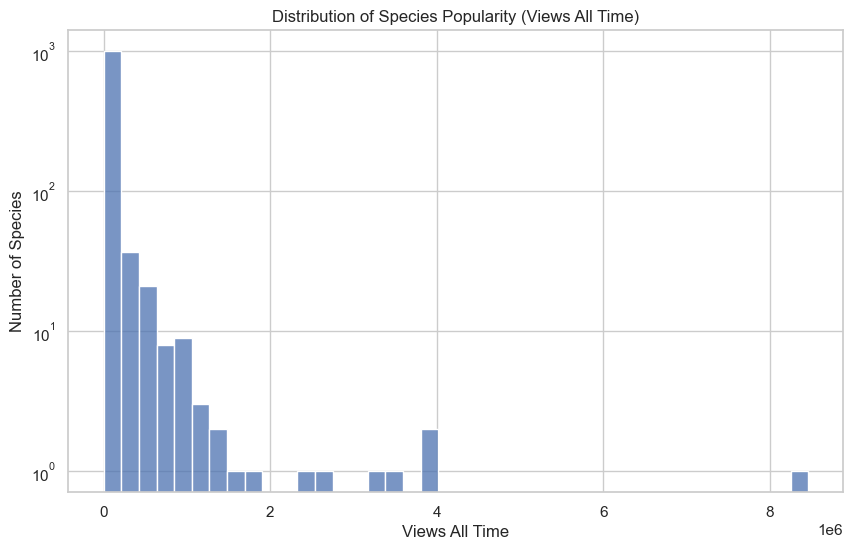

In [24]:
# Make sns histogram of views_all_time vs count of species
plt.figure(figsize=(10, 6))
sns.histplot(df['views_all_time'], bins=40, kde=False)
plt.title('Distribution of Species Popularity (Views All Time)')
plt.xlabel('Views All Time')
plt.ylabel('Number of Species')
plt.yscale('log')

/var/folders/sv/_w7_lr4s79bd9y8fpvjxy5d80000gn/T/ipykernel_47618/2918095255.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)
/var/folders/sv/_w7_lr4s79bd9y8fpvjxy5d80000gn/T/ipykernel_47618/2918095255.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)
/var/folders/sv/_w7_lr4s79bd9y8fpvjxy5d80000gn/T/ipykernel_47618/2918095255.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)
/var/folders/sv/_w7_lr4s79bd9y8fpvjxy5d80000gn/T/ipykernel_47618/2918095255.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)
/var/folders/sv/_w7_lr4s79bd9y8fpvjxy5d80000gn/T/ipykernel_47618/2918095255.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)


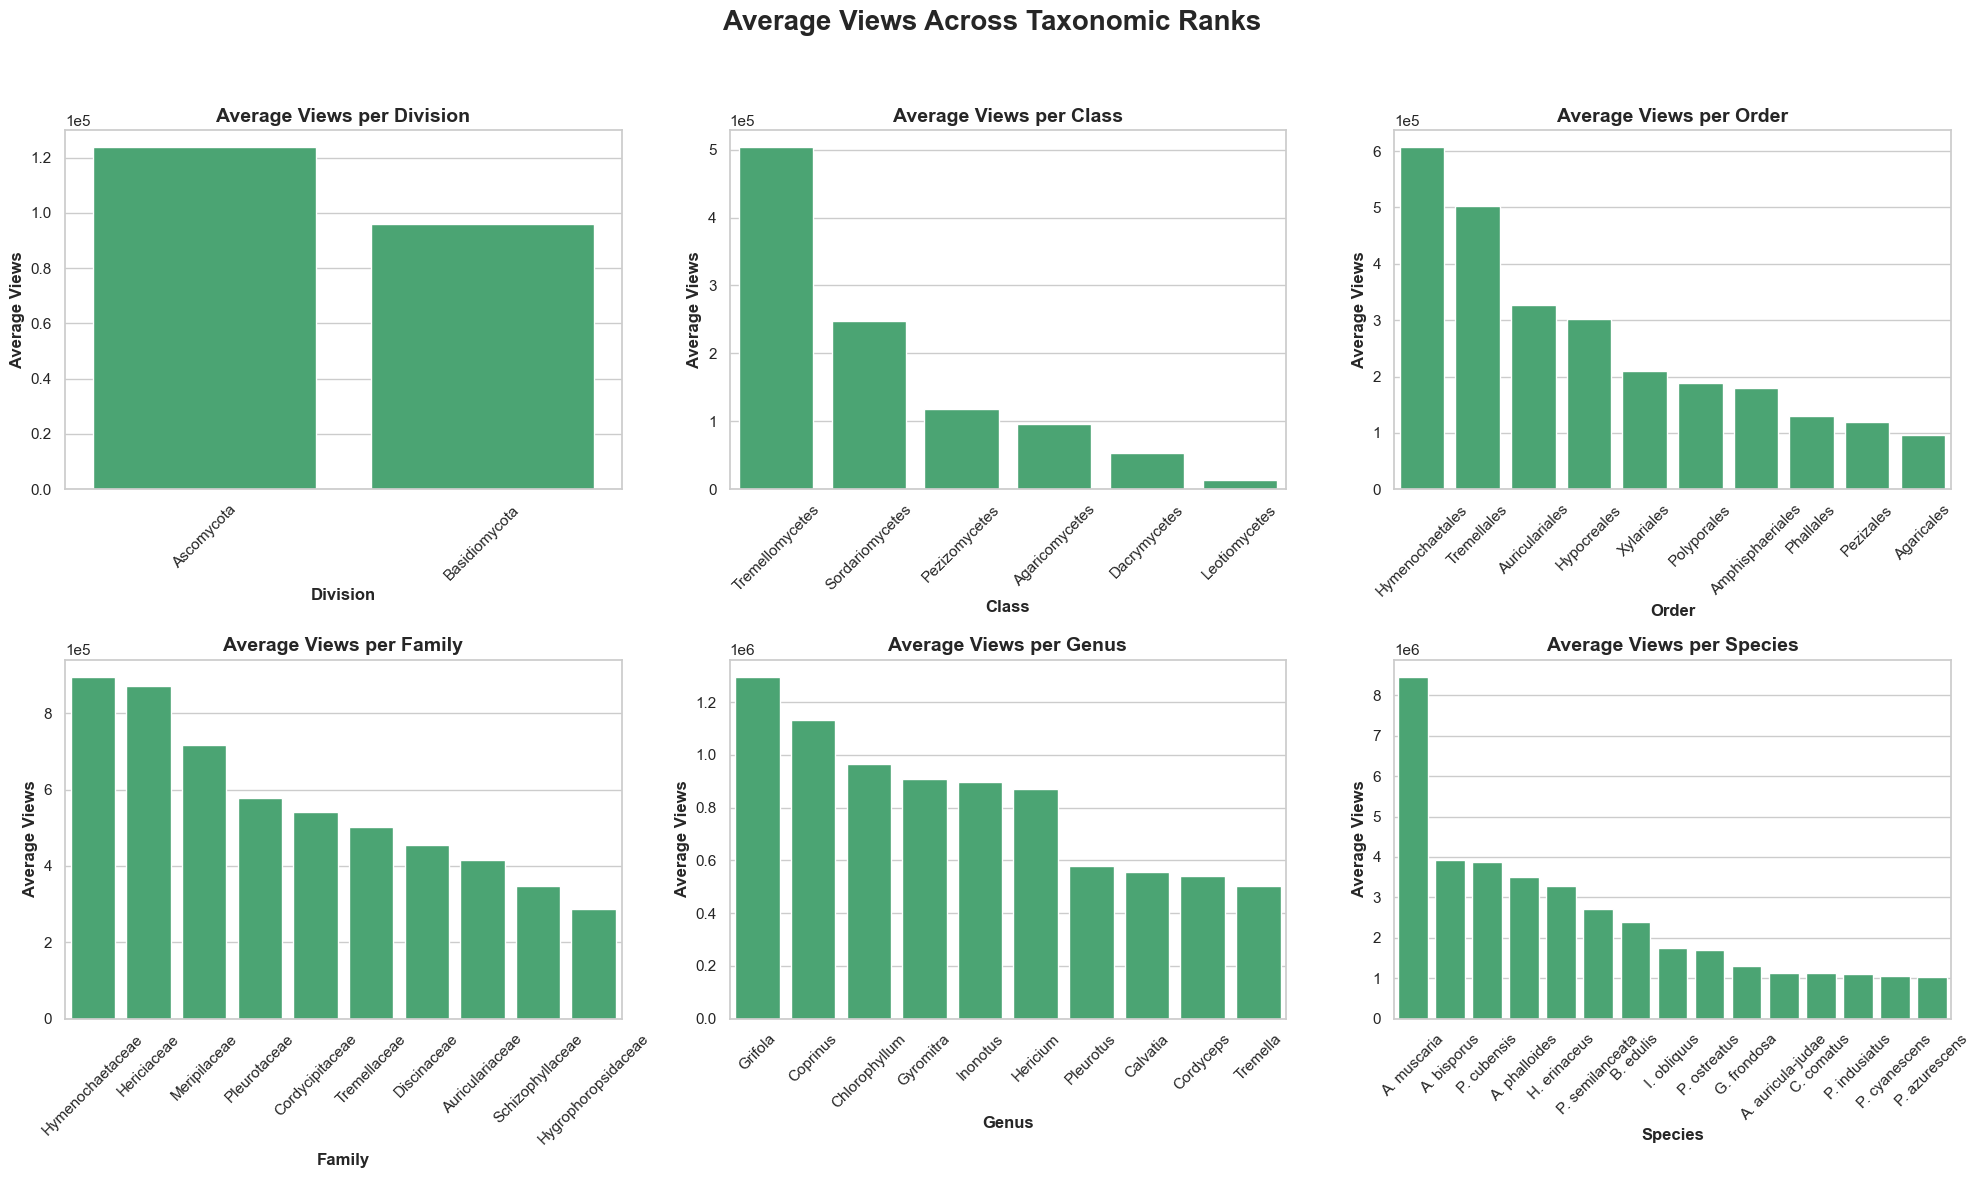

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import textwrap

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, rank in enumerate(tax_ranks):
    # 1. average views per level, sorted
    avg_views = (
        df.groupby(rank)['views_all_time']
          .mean()
          .sort_values(ascending=False)
    )

    # 2. choose how many to show
    if rank.lower() == "species":
        top_avg_views = avg_views.head(15)
    else:
        top_avg_views = avg_views.head(10)

    ax = axes[i]

    # 3. barplot
    sns.barplot(
        x=top_avg_views.index,
        y=top_avg_views.values,
        ax=ax,
        color="mediumseagreen"
    )

    # 4. titles & labels (bold)
    ax.set_title(f'Average Views per {rank}', fontsize=14, fontweight='bold')
    ax.set_xlabel(rank, fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Views', fontsize=12, fontweight='bold')

    # 5. scientific notation on y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    # 6. nicer x labels: wrap long names, no warning
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=45)

    fig.suptitle("Average Views Across Taxonomic Ranks", fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])


save_path = os.path.join("../../plots",
                         "views_per_taxonomic_rank.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()


Calculating Inequality (Gini) per rank...
Division: 0.4544
Class: 0.8037
Order: 0.8040
Family: 0.7438
Genus: 0.7901
Species: 0.8252


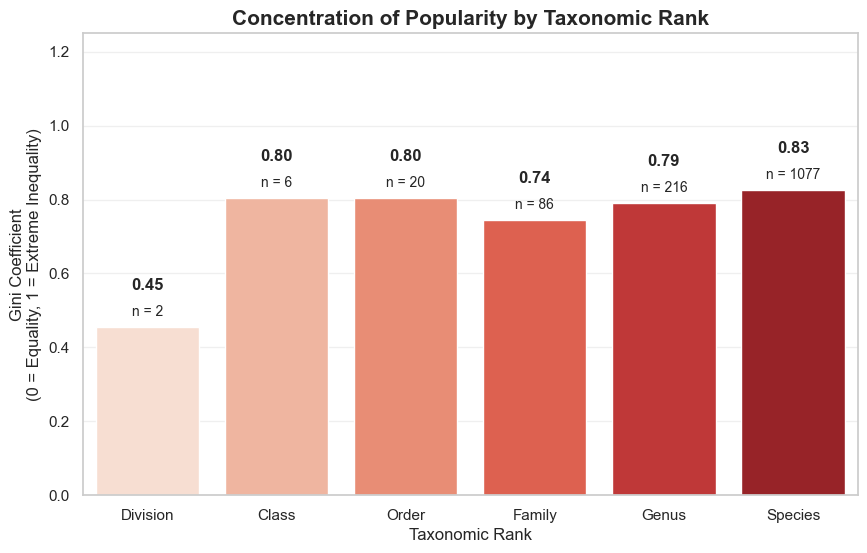

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Corrected Gini Function
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = np.asarray(array, dtype=float) 
    
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    
    array += 0.0000001 
    
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

# 2. Run the analysis
# Define ranks to check (skipping species as it is the base unit)
target_ranks = ['Division', 'Class', 'Order', 'Family', 'Genus', 'Species']
rank_gini_scores = []

print("Calculating Inequality (Gini) per rank...")

for rank in target_ranks:
    # Group by rank and sum the views to see the 'wealth' of that branch
    # We use SUM because we want to know if specific Families hold all the traffic
    group_views = df.groupby(rank)['views_all_time'].sum()
    
    # Calculate Gini
    score = gini(group_views.values)
    rank_gini_scores.append({'Rank': rank, 'Gini': score})
    print(f"{rank}: {score:.4f}")
# Compute number of unique groups per rank
unique_counts = {
    rank: df[rank].nunique()
    for rank in target_ranks
}

gini_df = pd.DataFrame(rank_gini_scores)
gini_df['Unique_Count'] = gini_df['Rank'].map(unique_counts)

plt.figure(figsize=(10, 6))

# Fix warning: assign hue and remove legend
sns.barplot(
    data=gini_df,
    x='Rank',
    y='Gini',
    hue='Rank',
    palette='Reds',
    legend=False
)

plt.ylim(0, 1.25)
plt.title('Concentration of Popularity by Taxonomic Rank', fontsize=15, fontweight='bold')
plt.ylabel('Gini Coefficient\n(0 = Equality, 1 = Extreme Inequality)', fontsize=12)
plt.xlabel('Taxonomic Rank', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add labels
for i, row in enumerate(gini_df.itertuples()):
    xloc = i
    gini_label = f"{row.Gini:.2f}"
    count_label = f"n = {row.Unique_Count}"
    
    plt.text(xloc, row.Gini + 0.03, count_label, ha='center', fontsize=10)
    plt.text(xloc, row.Gini + 0.10, gini_label, ha='center', fontweight='bold', fontsize=12)

save_path = os.path.join("../../plots",
                         "concentration_of_popularity_by_taxonomy.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight') 


plt.show()


As seen in Figure X, the Lorenz curves for Class, Order, Family, and Genus are nearly superimposed. This visually confirms the scale-invariant nature of popularity within the biological hierarchy."

In [27]:
# Print df summary
df.head()

,mushroom,id,views_all_time,article,sporePrintColor,howEdible,stipeCharacter,capShape,hymeniumType,ecologicalType,...,conservation_status,image,Genus,Family,Order,Class,Division,Species,text,wikilinks
1,Russula maculata,1,9897,https://en.wikipedia.org/wiki/Russula_maculata,"[yellow, ochre]",[],[bare],"[convex, depressed]","[adnexed, free]",[mycorrhizal],...,[],https://upload.wikimedia.org/wikipedia/commons...,Russula,Russulaceae,Russulales,Agaricomycetes,Basidiomycota,R. maculata,Russula maculata is a species of mushroom in t...,[{'url': 'https://en.wikipedia.org/wiki/Taxono...
2,Russula vinosa,2,14637,https://en.wikipedia.org/wiki/Russula_vinosa,[],[edible],[bare],"[convex, depressed]","[free, adnexed]",[mycorrhizal],...,[],https://upload.wikimedia.org/wikipedia/commons...,Russula,Russulaceae,Russulales,Agaricomycetes,Basidiomycota,R. vinosa,"Russula vinosa , commonly known as the darkeni...",[{'url': 'https://en.wikipedia.org/wiki/Taxono...
3,Gymnopilus pseudofulgens,3,1157,https://en.wikipedia.org/wiki/Gymnopilus_pseud...,[],[],[],[convex],"[adnexed, adnate]",[saprotrophic],...,[],https://upload.wikimedia.org/wikipedia/commons...,Gymnopilus,Hymenogastraceae,Agaricales,Agaricomycetes,Basidiomycota,G. pseudofulgens,Gymnopilus pseudofulgens is a species of mushr...,[{'url': 'https://en.wikipedia.org/wiki/Taxono...
4,Gymnopilus josserandii,4,2525,https://en.wikipedia.org/wiki/Gymnopilus_josse...,[ochre],[],[bare],[convex],"[adnexed, adnate]",[saprotrophic],...,[],https://upload.wikimedia.org/wikipedia/commons...,Gymnopilus,Hymenogastraceae,Agaricales,Agaricomycetes,Basidiomycota,G. josserandii,Gymnopilus josserandii is a species of mushroo...,[{'url': 'https://en.wikipedia.org/wiki/Taxono...
5,Albatrellus subrubescens,5,35128,https://en.wikipedia.org/wiki/Albatrellus_subr...,[white],[poisonous],[bare],"[convex, flat]",[decurrent],[mycorrhizal],...,[],https://upload.wikimedia.org/wikipedia/commons...,Albatrellus,Albatrellaceae,Russulales,Agaricomycetes,Basidiomycota,A. subrubescens,Albatrellus subrubescens is a species of polyp...,[{'url': 'https://en.wikipedia.org/wiki/Taxono...


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. sort by views descending (richest to poortes)
df_sorted = df.sort_values('views_all_time', ascending=False).reset_index(drop=True)

# 2. calculate cumulative sum of views
total_views = df_sorted['views_all_time'].sum()
df_sorted['cumulative_views'] = df_sorted['views_all_time'].cumsum()
df_sorted['cumulative_perc'] = df_sorted['cumulative_views'] / total_views

# 3. calculate population percentage (e.g., Mushroom 1 is 0.1%, Mushroom 100 is 10%)
n_mushrooms = len(df_sorted)
df_sorted['pop_perc'] = (df_sorted.index + 1) / n_mushrooms

# get the view percentage at exactly the 10% population mark
top_10_cutoff = int(n_mushrooms * 0.10)
views_at_10 = df_sorted.loc[top_10_cutoff, 'cumulative_perc'] * 100

# get the view percentage at the 20% mark (Pareto Principle check)
top_20_cutoff = int(n_mushrooms * 0.20)
views_at_20 = df_sorted.loc[top_20_cutoff, 'cumulative_perc'] * 100

print(f"Total Mushrooms: {n_mushrooms}")
print(f"The top 10% of mushrooms ({top_10_cutoff} species) account for {views_at_10:.2f}% of all traffic.")
print(f"The top 20% of mushrooms ({top_20_cutoff} species) account for {views_at_20:.2f}% of all traffic.")

# find how many mushrooms it takes to reach 50% of all views
mushrooms_for_50 = df_sorted[df_sorted['cumulative_perc'] <= 0.5].shape[0]
print(f"Just {mushrooms_for_50} specific mushrooms account for 50% of the total popularity.")

Total Mushrooms: 1091
The top 10% of mushrooms (109 species) account for 73.79% of all traffic.
The top 20% of mushrooms (218 species) account for 85.64% of all traffic.
Just 32 specific mushrooms account for 50% of the total popularity.
